In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [21]:
%%html

<a href="http://www.harvard.edu" target="_self">Back to the Home Page</a>

<style>
p {
  margin-top: 0em;
  margin-bottom: 2em;
}
</style>

# Chapter 1. Data Source #
_________
<h2><center>National Survey of Childern's Health (2007)</center></h2>

<font size="3"><a href="http://www.childhealthdata.org/learn/NSCH">The National Survey of Children’s Health (NSCH)</a> was conducted three times between 2003 and 2012 by the National Center for Health Statistics at the Centers for Disease Control. The surveys were conducted on children and teenagers from 0-17 years of age using telephone methodology, and provides rich data on multiple intersecting aspects of children’s lives, including physical and mental health, access to quality health care, and the child’s family and social context. </font>

<p><font size="3">We employed the 2007 survey to explore the factors that can be used to predict life-time epilepsy status and quality of life in children with epilepsy. The survey includes overall 91605 children.</font></p>


<font size = "3">
- [1.1. Survey Methodology](#1.1.Survey-Methodology)
- [1.2. Type of Questions](#1.2.Type-of-Questions)
- [1.3. Respondents with Epilepsy](#1.3.Respondents-with-epilepsy)
_______

In [12]:
import numpy as np
import matplotlib
import pandas as pd
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.preprocessing import StandardScaler as Standardize
from sklearn.cross_validation import KFold
from scipy import stats
from matplotlib import cm
from matplotlib import gridspec
from IPython.display import Image
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## 1.1.Survey Methodology ##
<font size="3"> A random-digit-dialed sample of households with children under age 18 years was selected from each of the 50 states and the District of Columbia. One child was randomly selected from all children in each identified household to be the subject of the survey. The respondent was a parent or guardian who knew about the child's health and health care.


_____

## 1.2.Type of Questions ##
<font size="3"> This survey was designed to produce national and state-specific prevalence estimates for a variety of physical, emotional, and behavioral health indicators and measures of children's experiences with the health care system. The survey also includes questions about the family (for example, parents' health status, stress and coping behaviors, family activities) and about respondents' perceptions of the neighborhoods where their children live.


____

## 1.3. Respondents with Epilepsy ##
<font size="3">Among these children, 977 have had epilepsy and 562 currently have it, resulting in a low (1.1%) lifetime incidence of epilepsy [<b>Figure 1 Left</b>]. The severity of epilepsy was assessed in children currently with epilepsy on a scale of mild, moderate, and severe. Of 526 children with current epilepsy, the majority (59.3%) described their epilepsy as mild, (23.6%) moderate, and (14.6%) severe [<b>Figure 1 Right</b>]. In the survey, epilepsy equally affects male and female children, with the percentage increases in older children [<b>Figure 2</b>], which is consistant with the survey as an one-time observation of the epilepsy history.</font>.

____

<font size="4"><b> Figure 1. Epilepsy prevalance and severity in NSCH 2007.</b></font>
<p></p>
<font size="3">The survey data is consistent with about 1% prevalence of epilepsy, which indicates a severe calss imbalance in the dataset. The severity of current epilepsy is shown on the right.</font>


In [ ]:
# read the data
data = pd.read_csv("NSCH_2007.csv")

# split into epilepsy and non-epilepsy dataframes
epilepsy = data[data['K2Q42A'] == 1]
non_epilepsy = data[data['K2Q42A'] == 0]

# pie chart on the population
count = [epilepsy.shape[0], non_epilepsy.shape[0]]
count = np.asarray(count)
percent =count*100/float(count[0]+count[1])

label = ["Epilepsy: {} ({}%)".format(count[0], round(percent[0],2)), "Non-epilepsy: {} ({}%)".format(count[1], round(percent[1],2))]

fig = plt.figure(figsize = (15, 7))
ax1 = fig.add_subplot(121)
ax1.pie (count, labels = label, colors=['red','gold'], startangle=45)
ax1.set_title('Epilepsy vs non-epilepsy')


#### PIE CHARTS OF GENERAL PATIENT DEMOGRAPHICS
# Epilepsy Status: Excluding people who don't know
# Focus on people with Epilepsy (EVER)

def get_counts_frac (data, var_label, var_levels):
    counts = [np.sum(data[var_label] == i) for i in var_levels ]
    frac = np.array(counts)/ float(np.sum(counts))
    return counts, frac

epilepsy_levels = [0, 1, 6, 7] # 0 (no), 1 (yes), 6 (IDK), 7(No response)
epilepsy_names = ['Non-Epilepsy', 'Epilepsy', 'Don\'t know', 'No response']

matplotlib.rcParams['font.size'] = 16
epilepsy_status_counts, epilepsy_status_fracs = get_counts_frac (data, 'K2Q42A', epilepsy_levels)
ax2 = fig.add_subplot(122)
plt.pie(epilepsy_status_fracs[:2] , labels = epilepsy_names[:2], colors = ['deepskyblue', 'red'],
                autopct='%1.1f%%', shadow=False, startangle=75)
plt.title('Epilepsy Status', fontsize = 18)

plt.tight_layout()
plt.show()

# polish the figure and reload from jpg

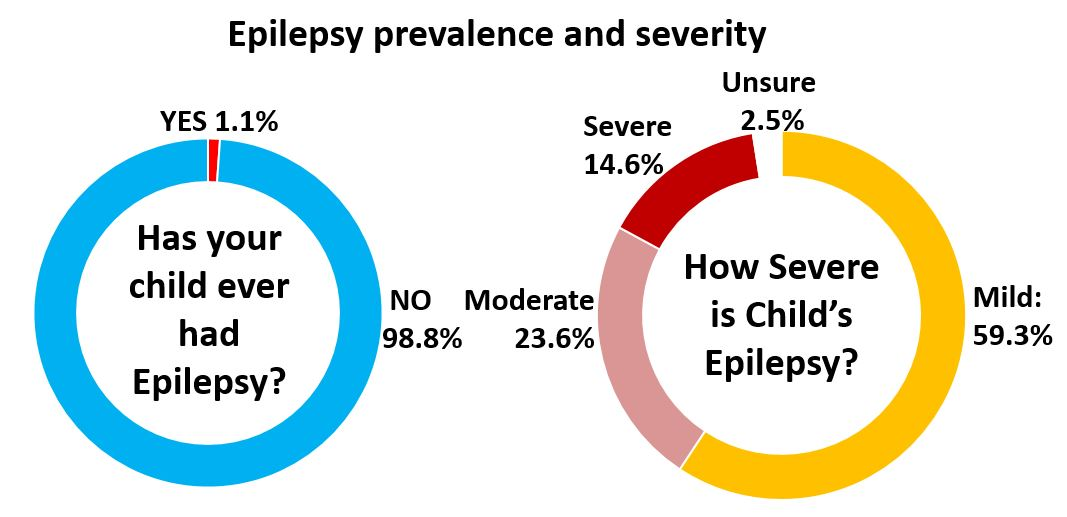

In [37]:
Image(filename='pic/data_1.jpg', width = 700)

<p></p>
<font size="4"><b> Figure 2. Age and gender distribution of children with epilepsy history.</b></font>
<p></p>
<font size="3">The gender ratio is the same in children ever diagnosed with epilepsy and other children, with a male-to-female ratio of 52-48. The number of children who have ever been diagnosed with seizures or epilepsy increases as the age grows, as the number in this category is the cumulative. There is no obvious interaction between age and gender in the two groups. </font>

In [31]:
# plot age-gender in both epilepsy and non-epilepsy groups
# separate gender 
epilepsy_F = epilepsy[epilepsy['SEX'] == 2]
epilepsy_M = epilepsy[epilepsy['SEX'] == 1]
non_epilepsy_F = non_epilepsy[non_epilepsy['SEX'] == 2]
non_epilepsy_M = non_epilepsy[non_epilepsy['SEX'] == 1]

# percentage of genders in both groups
Female_percent_epi = epilepsy_F.shape[0]/float(epilepsy.shape[0])
Female_percent_non = non_epilepsy_F.shape[0]/float(non_epilepsy.shape[0])

count_epi = [Female_percent_epi, 1-Female_percent_epi]
count_non = [Female_percent_non, 1-Female_percent_non]


# get how many age years are covered
ages = data['AGEYR_CHILD'].unique()
ages = np.sort(ages)

# count for the epilepsy group
age_count_epilepsy =[]

for age in ages:
    c_F = sum(epilepsy_F['AGEYR_CHILD']== age)
    c_M = sum(epilepsy_M['AGEYR_CHILD']== age)
    age_count_epilepsy.append([c_F, c_M])
    
age_count_epilepsy = np.asarray(age_count_epilepsy)

# count for the non-epilepsy group
age_count_non = []

for age in ages:
    c_F = sum(non_epilepsy_F['AGEYR_CHILD']== age)
    c_M = sum(non_epilepsy_M['AGEYR_CHILD']== age)
    age_count_non.append([c_F, c_M])
    
age_count_non = np.asarray(age_count_non)


# generate the stacked bar plot
fig = plt.figure(figsize = (15, 10))
matplotlib.rcParams['font.size'] = 14

# create the locations of the bars
num_bar = len(ages)
bar = [i*1 for i in range(num_bar)] 
bar_width = 0.8
# labels
label = ['Female', 'Male']
color = ['salmon', 'steelblue']

gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2]) 

# for epilepsy group
ax1 = fig.add_subplot(gs[1])

Bottom = np.zeros(num_bar)
for i  in range(2):
    ax1.bar(bar, age_count_epilepsy[:,i], width=bar_width, label=label[i], bottom = Bottom, color=color[i])
    Bottom = np.add(Bottom, age_count_epilepsy[:,i])
    
tickers = [i+(bar_width) for i in bar] 
plt.xticks(tickers, ages)
plt.legend(loc='upper left', fontsize = 16)

ax1.set_title("Age and Gender in Epilepsy Respondents", fontsize = 18)
ax1.set_xlabel("Age (year)", fontsize = 16)
ax1.set_ylabel("Population", fontsize = 16)

# for non-epilepsy group
ax2 = fig.add_subplot(gs[3])
Bottom = np.zeros(num_bar)
for i  in range(2):
    ax2.bar(bar, age_count_non[:,i], width=bar_width, label=label[i], bottom = Bottom, color=color[i])
    Bottom = np.add(Bottom, age_count_non[:,i])
    
tickers = [i+(bar_width) for i in bar] 
plt.xticks(tickers, ages)
plt.legend(loc='upper left', fontsize = 16)

ax2.set_title("Age and Gender in Non-Epilepsy Respondents", fontsize = 18)
ax2.set_xlabel("Age (year)", fontsize = 16)
ax2.set_ylabel("Population", fontsize = 16)


# pie charts of the gender ratio in both groups
ax3 = fig.add_subplot(gs[0])
ax3.pie (count_epi, labels = label, colors=['salmon','steelblue'], startangle=45, autopct='%1.1f%%')
ax3.set_title('Male vs Female in Epilepsy Respondents', fontsize = 18)

ax4 = fig.add_subplot(gs[2])
ax4.pie (count_non, labels = label, colors=['salmon','steelblue'], startangle=45, autopct='%1.1f%%')
ax4.set_title('Male vs Female in Non-Epilepsy Respondents', fontsize = 18)

plt.tight_layout()
plt.show()

# polish the figure and reload from jpg

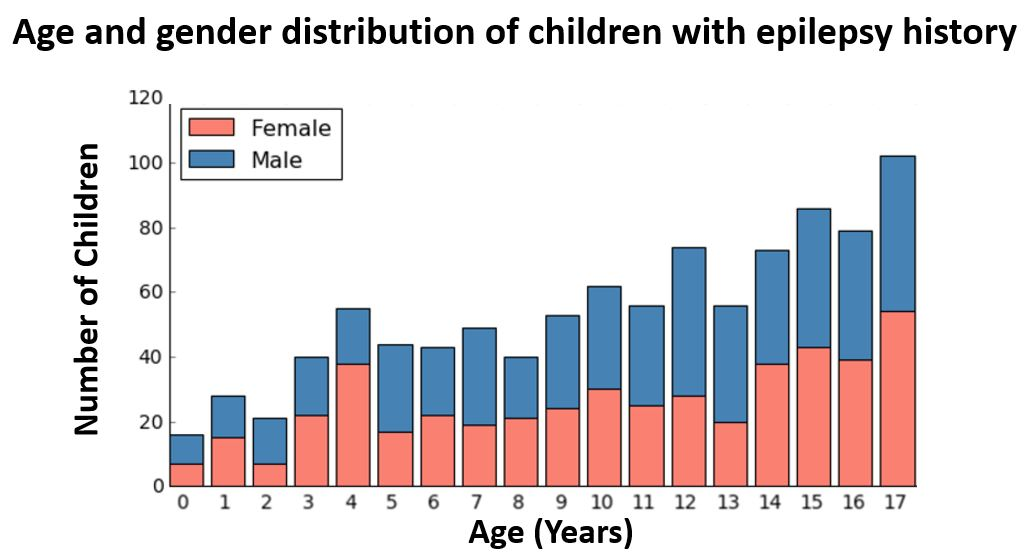

In [38]:
Image(filename='pic/data_2.jpg', width = 700)

_______________________

In [32]:
%%html
<a href="http://www.harvard.edu" target="_self">Chapter 2. Imputation</a>

In [24]:
%%html
<a href="http://www.harvard.edu" target="_self">Back to the Home Page</a>